In [1]:
url = "https://raw.githubusercontent.com/siddley1001/Resume_Extraction/main/Resume.json"


import pandas as pd
import numpy as np
import spacy as sp
import os
from collections import defaultdict
import matplotlib.pyplot as plt

import json
import requests

path = '/content/Resume.json'
data = [json.loads(line) for line in open(path, 'r')]

In [2]:
def pop_annot(raw_line):
    in_line = defaultdict(list, **raw_line)
    if 'annotation' in in_line:
        labels = in_line['annotation']

        for c_lab in labels:
            if len(c_lab['label']) > 0:
                in_line[c_lab['label'][0]] += c_lab['points']
    return in_line

def extract_highlights(raw_line):
    in_line = defaultdict(list, **raw_line)
    if 'annotation' in in_line:
        labels = in_line['annotation']
        for c_lab in labels:
            if len(c_lab['label']) > 0:
                in_line['highlight'] += [dict(category = c_lab['label'][0], **cpts) for cpts in c_lab['points']]
    return in_line

def result_to_vec(in_row, focus_col):
    let_vec = in_row['kosher_content']
    attn_vec = np.zeros((len(let_vec)))

    for yoe in c_row[focus_col]:
        s,e = yoe['start'], yoe['end']
        attn_vec[s:e+1] = 1.0
    return let_vec, attn_vec

In [3]:
with open(path, 'r') as f:
    #parse the data line-by-line
    resume_data = [json.loads(file_line) for file_line in f.readlines()]
    resume_df = pd.DataFrame([pop_annot(line) for line in resume_data])

resume_df['length'] = resume_df['content'].map(len)

resume_df.sample(3)

,content,annotation,Companies worked at,Skills,Graduation Year,College Name,Degree,Designation,Email Address,Location,Name,Years of Experience,UNKNOWN,length
156,Ajay Elango\nSoftware Engineer\n\nBangalore Ci...,"[{'label': ['Skills'], 'points': [{'start': 69...",NaN,"[{'start': 6930, 'end': 7493, 'text': 'C++ (6 ...",NaN,"[{'start': 6845, 'end': 6874, 'text': 'Amrita ...","[{'start': 6778, 'end': 6842, 'text': 'Bachelo...",NaN,NaN,NaN,NaN,NaN,NaN,7549
9,Karthik GV\nArchitect - Microsoft India\n\nHyd...,"[{'label': ['Skills'], 'points': [{'start': 40...","[{'start': 3822, 'end': 3836, 'text': 'Microso...","[{'start': 4048, 'end': 4168, 'text': 'Program...","[{'start': 4034, 'end': 4037, 'text': '2018'},...","[{'start': 3977, 'end': 4021, 'text': 'Narsee ...","[{'start': 3970, 'end': 3974, 'text': 'PGDBM'}]","[{'start': 3804, 'end': 3819, 'text': 'Sr Test...",NaN,"[{'start': 3841, 'end': 3849, 'text': 'Hyderab...","[{'start': 0, 'end': 9, 'text': 'Karthik GV'}]",NaN,NaN,8041
193,Moumita Mitra\n- Email me on Indeed: indeed.co...,"[{'label': ['Skills'], 'points': [{'start': 19...",NaN,"[{'start': 1963, 'end': 2093, 'text': 'Compute...",NaN,"[{'start': 1741, 'end': 1758, 'text': 'St. Pau...","[{'start': 1732, 'end': 1738, 'text': 'C.B.S.E...",NaN,"[{'start': 35, 'end': 79, 'text': ' indeed.com...",NaN,"[{'start': 0, 'end': 12, 'text': 'Moumita Mitr...",NaN,NaN,2094


Text(0.5, 1.0, 'Length of Resumes (in words)')

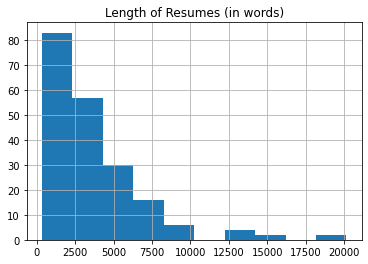

In [4]:
resume_df['length'].hist()
plt.title('Length of Resumes (in words)')

In [5]:
resume_hl_df = pd.DataFrame([extract_highlights(line) for line in resume_data])
resume_hl_df['length'] = resume_hl_df['content'].map(len)
resume_hl_df.sample(3)

,content,annotation,highlight,length
193,Moumita Mitra\n- Email me on Indeed: indeed.co...,"[{'label': ['Skills'], 'points': [{'start': 19...","[{'category': 'Skills', 'start': 1963, 'end': ...",2094
95,Asha Subbaiah\n(Microsoft Partner Readiness Op...,"[{'label': ['College Name'], 'points': [{'star...","[{'category': 'College Name', 'start': 3345, '...",3416
42,Ramesh HP\nCES ASSOCIATE CONSULTANT\n\nBangalo...,"[{'label': ['Skills'], 'points': [{'start': 26...","[{'category': 'Skills', 'start': 2668, 'end': ...",3258


Text(0.5, 1.0, 'Length of Resumes (in words)')

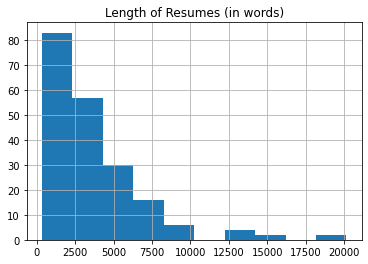

In [6]:
resume_hl_df['length'].hist()
plt.title('Length of Resumes (in words)')

In [7]:
from string import ascii_lowercase, digits

valid_chars = ascii_lowercase + digits + '@., '
focus_col = 'highlight'
focus_df = resume_hl_df[['content', focus_col, 'length']].copy().dropna()

#clean text but maintain the length
focus_df['kosher_content'] = resume_df['content'].str.lower().map(lambda c_text: ''.join([c if c in valid_chars else " " for c in c_text]))

print(focus_col, 'with', focus_df.shape[0], 'complete results')

highlight with 200 complete results


In [8]:
print('First result')
for _, c_row in focus_df.query('length < 2000').sample(1, random_state=20).iterrows():
    print(len(c_row['content']))
    for yoe in c_row[focus_col]:
        s,e = yoe['start'], yoe['end']
        print(yoe)
        print(c_row['content'][s:e+1])

First result
1318
{'category': 'Email Address', 'start': 1234, 'end': 1276, 'text': 'indeed.com/r/Gunjan-Nayyar/a5819ca6733a0f41'}
indeed.com/r/Gunjan-Nayyar/a5819ca6733a0f41
{'category': 'Graduation Year', 'start': 1146, 'end': 1149, 'text': '2018'}
2018
{'category': 'College Name', 'start': 1117, 'end': 1136, 'text': 'Chitkara University\n'}
Chitkara University

{'category': 'Degree', 'start': 1103, 'end': 1115, 'text': 'B. E. in CSE\n'}
B. E. in CSE

{'category': 'Designation', 'start': 417, 'end': 459, 'text': 'Member of Discipline Committee in ALGORYTHM'}
Member of Discipline Committee in ALGORYTHM
{'category': 'Designation', 'start': 276, 'end': 318, 'text': 'Member of Discipline Committee in ALGORYTHM'}
Member of Discipline Committee in ALGORYTHM
{'category': 'Companies worked at', 'start': 267, 'end': 273, 'text': 'INFOSYS'}
INFOSYS
{'category': 'Companies worked at', 'start': 258, 'end': 264, 'text': 'INFOSYS'}
INFOSYS
{'category': 'Years of Experience', 'start': 235, 'end': 2

In [9]:
focus_df.head()

,content,highlight,length,kosher_content
0,Govardhana K\nSenior Software Engineer\n\nBeng...,"[{'category': 'Companies worked at', 'start': ...",1845,govardhana k senior software engineer bengalu...
1,"Harini Komaravelli\nTest Analyst at Oracle, Hy...","[{'category': 'Companies worked at', 'start': ...",5203,"harini komaravelli test analyst at oracle, hyd..."
2,Hartej Kathuria\nData Analyst Intern - Oracle ...,"[{'category': 'Skills', 'start': 2246, 'end': ...",2573,hartej kathuria data analyst intern oracle r...
3,Ijas Nizamuddin\nAssociate Consultant - State ...,"[{'category': 'Skills', 'start': 4652, 'end': ...",4850,ijas nizamuddin associate consultant state s...
4,"Imgeeyaul Ansari\njava developer\n\nPune, Maha...","[{'category': 'Skills', 'start': 1894, 'end': ...",2173,"imgeeyaul ansari java developer pune, maharas..."


In [10]:
focus_df.iloc[0,3]

'govardhana k senior software engineer  bengaluru, karnataka, karnataka   email me on indeed  indeed.com r govardhana k  b2de315d95905b68  total it experience 5 years 6 months cloud lending solutions inc 4 month   salesforce developer oracle 5 years 2 month   core java developer languages core java, go lang oracle pl sql programming, sales force developer with apex.  designations   promotions  willing to relocate  anywhere  work experience  senior software engineer  cloud lending solutions    bangalore, karnataka    january 2018 to present  present  senior consultant  oracle    bangalore, karnataka    november 2016 to december 2017  staff consultant  oracle    bangalore, karnataka    january 2014 to october 2016  associate consultant  oracle    bangalore, karnataka    november 2012 to december 2013  education  b.e in computer science engineering  adithya institute of technology    tamil nadu  september 2008 to june 2012  https   www.indeed.com r govardhana k b2de315d95905b68 isid rex d

In [11]:
focus_df.loc[0, 'content']

'Govardhana K\nSenior Software Engineer\n\nBengaluru, Karnataka, Karnataka - Email me on Indeed: indeed.com/r/Govardhana-K/\nb2de315d95905b68\n\nTotal IT experience 5 Years 6 Months\nCloud Lending Solutions INC 4 Month • Salesforce Developer\nOracle 5 Years 2 Month • Core Java Developer\nLanguages Core Java, Go Lang\nOracle PL-SQL programming,\nSales Force Developer with APEX.\n\nDesignations & Promotions\n\nWilling to relocate: Anywhere\n\nWORK EXPERIENCE\n\nSenior Software Engineer\n\nCloud Lending Solutions -  Bangalore, Karnataka -\n\nJanuary 2018 to Present\n\nPresent\n\nSenior Consultant\n\nOracle -  Bangalore, Karnataka -\n\nNovember 2016 to December 2017\n\nStaff Consultant\n\nOracle -  Bangalore, Karnataka -\n\nJanuary 2014 to October 2016\n\nAssociate Consultant\n\nOracle -  Bangalore, Karnataka -\n\nNovember 2012 to December 2013\n\nEDUCATION\n\nB.E in Computer Science Engineering\n\nAdithya Institute of Technology -  Tamil Nadu\n\nSeptember 2008 to June 2012\n\nhttps://www.

In [12]:
focus_df['kosher_content'][0]

'govardhana k senior software engineer  bengaluru, karnataka, karnataka   email me on indeed  indeed.com r govardhana k  b2de315d95905b68  total it experience 5 years 6 months cloud lending solutions inc 4 month   salesforce developer oracle 5 years 2 month   core java developer languages core java, go lang oracle pl sql programming, sales force developer with apex.  designations   promotions  willing to relocate  anywhere  work experience  senior software engineer  cloud lending solutions    bangalore, karnataka    january 2018 to present  present  senior consultant  oracle    bangalore, karnataka    november 2016 to december 2017  staff consultant  oracle    bangalore, karnataka    january 2014 to october 2016  associate consultant  oracle    bangalore, karnataka    november 2012 to december 2013  education  b.e in computer science engineering  adithya institute of technology    tamil nadu  september 2008 to june 2012  https   www.indeed.com r govardhana k b2de315d95905b68 isid rex d

In [13]:
import spacy

nlp = spacy.load("en")

In [15]:
def pos(sent):
    se=nlp(sent)
    for word in se:
        print(word,word.pos_)

In [16]:
pos(focus_df['kosher_content'][0])

govardhana PROPN
k PROPN
senior ADJ
software NOUN
engineer NOUN
  SPACE
bengaluru PROPN
, PUNCT
karnataka PROPN
, PUNCT
karnataka PROPN
   SPACE
email VERB
me PRON
on ADP
indeed ADV
  SPACE
indeed.com X
r PROPN
govardhana PROPN
k PROPN
  SPACE
b2de315d95905b68 PROPN
  SPACE
total NOUN
it PRON
experience VERB
5 NUM
years NOUN
6 NUM
months NOUN
cloud PROPN
lending PROPN
solutions PROPN
inc PROPN
4 NUM
month NOUN
   SPACE
salesforce ADJ
developer NOUN
oracle NOUN
5 NUM
years NOUN
2 NUM
month NOUN
   SPACE
core NOUN
java PROPN
developer PROPN
languages PROPN
core PROPN
java PROPN
, PUNCT
go VERB
lang PROPN
oracle PROPN
pl PROPN
sql PROPN
programming NOUN
, PUNCT
sales NOUN
force NOUN
developer NOUN
with ADP
apex NOUN
. PUNCT
  SPACE
designations NOUN
   SPACE
promotions NOUN
  SPACE
willing ADJ
to PART
relocate VERB
  SPACE
anywhere ADV
  SPACE
work NOUN
experience NOUN
  SPACE
senior ADJ
software NOUN
engineer NOUN
  SPACE
cloud NOUN
lending PROPN
solutions PROPN
    SPACE
bangalore PROPN

In [17]:
from spacy.lang.en import English

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()

text = focus_df['kosher_content'][0]

my_doc = nlp(text)

In [18]:
# Create list of word tokens
token_list = []
for token in my_doc:
    token_list.append(token.text)
print(token_list)

['govardhana', 'k', 'senior', 'software', 'engineer', ' ', 'bengaluru', ',', 'karnataka', ',', 'karnataka', '  ', 'email', 'me', 'on', 'indeed', ' ', 'indeed.com', 'r', 'govardhana', 'k', ' ', 'b2de315d95905b68', ' ', 'total', 'it', 'experience', '5', 'years', '6', 'months', 'cloud', 'lending', 'solutions', 'inc', '4', 'month', '  ', 'salesforce', 'developer', 'oracle', '5', 'years', '2', 'month', '  ', 'core', 'java', 'developer', 'languages', 'core', 'java', ',', 'go', 'lang', 'oracle', 'pl', 'sql', 'programming', ',', 'sales', 'force', 'developer', 'with', 'apex', '.', ' ', 'designations', '  ', 'promotions', ' ', 'willing', 'to', 'relocate', ' ', 'anywhere', ' ', 'work', 'experience', ' ', 'senior', 'software', 'engineer', ' ', 'cloud', 'lending', 'solutions', '   ', 'bangalore', ',', 'karnataka', '   ', 'january', '2018', 'to', 'present', ' ', 'present', ' ', 'senior', 'consultant', ' ', 'oracle', '   ', 'bangalore', ',', 'karnataka', '   ', 'november', '2016', 'to', 'december', '

In [ ]:
sent_list=[]
for token in my_doc.sents:
    sent_list.append(token.text)
print(sent_list)

In [21]:
import en_core_web_sm

# load en_core_web_sm of English for vocabluary, syntax & entities
nlp = en_core_web_sm.load()

#  "nlp" Objectis used to create documents with linguistic annotations.
docs = nlp(focus_df['kosher_content'][0])

In [22]:
for word in docs:
    print(word.text,word.pos_)

govardhana PROPN
k PROPN
senior ADJ
software NOUN
engineer NOUN
  SPACE
bengaluru PROPN
, PUNCT
karnataka PROPN
, PUNCT
karnataka PROPN
   SPACE
email VERB
me PRON
on ADP
indeed ADV
  SPACE
indeed.com X
r PROPN
govardhana PROPN
k PROPN
  SPACE
b2de315d95905b68 PROPN
  SPACE
total NOUN
it PRON
experience VERB
5 NUM
years NOUN
6 NUM
months NOUN
cloud PROPN
lending PROPN
solutions PROPN
inc PROPN
4 NUM
month NOUN
   SPACE
salesforce ADJ
developer NOUN
oracle NOUN
5 NUM
years NOUN
2 NUM
month NOUN
   SPACE
core NOUN
java PROPN
developer PROPN
languages PROPN
core PROPN
java PROPN
, PUNCT
go VERB
lang PROPN
oracle PROPN
pl PROPN
sql PROPN
programming NOUN
, PUNCT
sales NOUN
force NOUN
developer NOUN
with ADP
apex NOUN
. PUNCT
  SPACE
designations NOUN
   SPACE
promotions NOUN
  SPACE
willing ADJ
to PART
relocate VERB
  SPACE
anywhere ADV
  SPACE
work NOUN
experience NOUN
  SPACE
senior ADJ
software NOUN
engineer NOUN
  SPACE
cloud NOUN
lending PROPN
solutions PROPN
    SPACE
bangalore PROPN

In [24]:
from spacy import displacy

nytimes= nlp(focus_df['kosher_content'][0])

entities=[(i, i.label_, i.label) for i in nytimes.ents]
entities

[(govardhana k, 'PERSON', 380),
 (bengaluru, 'GPE', 384),
 (karnataka, 'GPE', 384),
 (karnataka, 'GPE', 384),
 (indeed.com, 'ORG', 383),
 (5 years 6 months, 'DATE', 391),
 (4 month, 'DATE', 391),
 (2 month, 'DATE', 391),
 (lang, 'ORG', 383),
 (pl sql programming, 'PERSON', 380),
 (apex, 'ORG', 383),
 (bangalore, 'GPE', 384),
 (karnataka, 'GPE', 384),
 (january 2018, 'DATE', 391),
 (bangalore, 'GPE', 384),
 (karnataka, 'GPE', 384),
 (november 2016 to december 2017, 'DATE', 391),
 (bangalore, 'GPE', 384),
 (karnataka, 'GPE', 384),
 (january 2014 to october 2016, 'DATE', 391),
 (bangalore, 'GPE', 384),
 (karnataka, 'GPE', 384),
 (november 2012 to december 2013, 'DATE', 391),
 (adithya institute of technology, 'ORG', 383),
 (september 2008 to june 2012, 'DATE', 391),
 (less than 1 year, 'DATE', 391),
 (3 years, 'DATE', 391),
 (flexcube, 'ORG', 383),
 (5 years, 'DATE', 391),
 (5 years, 'DATE', 391),
 (3 years, 'DATE', 391),
 (go lang, 'PERSON', 380),
 (pl sql programming, 'PERSON', 380),
 (

In [25]:
displacy.render(nytimes, style = "ent",jupyter = True)